In [1]:
using PyPlot, StatsBase, Printf, DelimitedFiles;
using Revise;
using MDToolbox;
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/nakayama/.julia/packages/Revise/AMRie/src/Revise.jl:1167
┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/nakayama/.julia/packages/CUDAdrv/aBgcd/src/CUDAdrv.jl:69


### Potential energy function its gradients

In [22]:
V(x; k=1.0) = sum(- (1.0 / 2.0) .* k .* x.^2 .+ (1.0 ./ 4.0) .* k .* x.^4)
V([0.0])

0.0

In [23]:
grad(x; k= 1.0) =  - k .* x .+ k .* x.^3

grad (generic function with 1 method)

### Replica MD with exchange

In [24]:
function exchange_temperature!(m2i, i2m, icount, x_replica, pot_fun::Function, temperature_replica)
    nreplica = length(x_replica)

    m_array = 1:nreplica
    t_array = temperature_replica[m_array]
    b_array = 1.0 ./ t_array
    i_array = m2i[m_array]
    v_array = map(pot_fun, x_replica[i_array])
    
    if mod(icount, 2) == 0
        m_lower = 1:2:(nreplica-1)
        m_higher = 2:2:nreplica
    else
        m_lower = 2:2:(nreplica-1)
        m_higher = 3:2:nreplica
    end
    
    iaccepted = 0
    for ipair = 1:length(m_higher)
        m1 = m_lower[ipair]
        m2 = m_higher[ipair]
        delta = (b_array[m2] - b_array[m1]) * (v_array[m1] - v_array[m2])
        if exp(-delta) > rand()
            m2i[m_array[m1]], m2i[m_array[m2]] = m2i[m_array[m2]], m2i[m_array[m1]]
            i2m[i_array[m1]], i2m[i_array[m2]] = i2m[i_array[m2]], i2m[i_array[m1]]
            iaccepted += 1
        end
    end

    return iaccepted / length(m_higher)
end

exchange_temperature! (generic function with 1 method)

In [11]:
nreplica = 4
temperature_replica = [0.01, 0.10, 0.30, 0.40];
nstep = 100;
nexchange = 10;
nset=10;
m2i = collect(1:nreplica)
i2m = collect(1:nreplica)


for j=1:nset

x_replica = []
for i = 1:nreplica
    x = [0.0]
    push!(x_replica, x)
end

io_replica = []
for i = 1:nreplica
    filename = "./REMDdeta/replica$(i)_$(j)set.dat"
    io = open(filename, "w")
    push!(io_replica, io)
end

icount = 0
acceptance_ratio = 0.0
for iexchange = 1:nexchange
    for i = 1:nreplica
        x_replica[i] = propagate_md(grad, x_replica[i], temperature_replica[i2m[i]], nstep=nstep, io=io_replica[i]);
    end
    # do exchange
    acceptance_ratio += exchange_temperature!(m2i, i2m, icount, x_replica, y -> V(y, k=1.0), temperature_replica)
    icount += 1
end

for i = 1:nreplica
    close(io_replica[i])
end

end
#acceptance_ratio = acceptance_ratio / nexchange

### Trajectory analysis

In [12]:
traj_replica = []
temp_replica = []

for i = 1:nreplica
    filename = "./REMDdeta/replica$(i)_1set.dat"
    data = readdlm(filename);
    push!(temp_replica, data[:, 1])
    push!(traj_replica, data[:, 2])
end

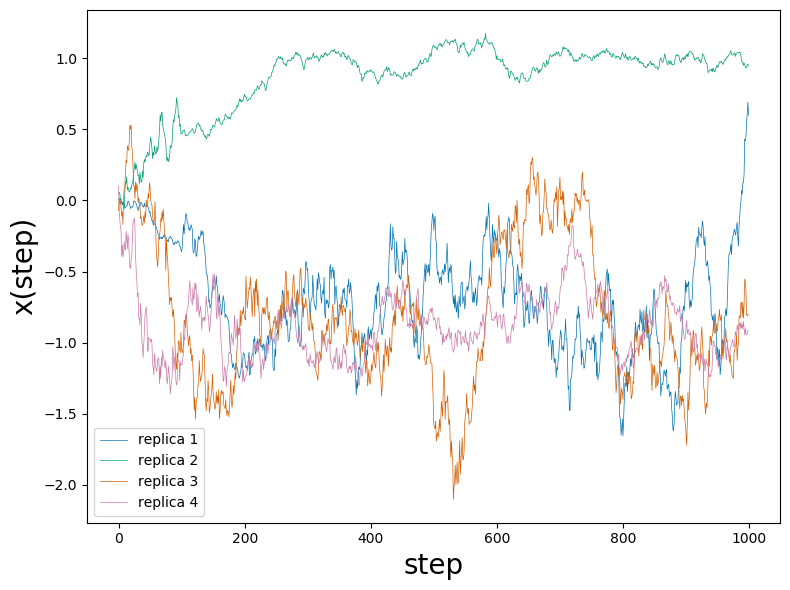

In [13]:
fig, ax = subplots(figsize=(8, 6))
for i = 1:nreplica
    ax.plot(traj_replica[i], linewidth=0.5)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["replica 1", "replica 2", "replica 3", "replica 4"])
tight_layout()

In [14]:
# sort trajectories according to temperature
function sort_traj(traj_replica, temp_replica)
    traj_sorted = deepcopy(traj_replica)
    temp_sorted = deepcopy(temp_replica)
    nframe = size(traj_replica[1], 1)
    for iframe = 1:nframe
        temp_snapshot = map(x -> x[iframe], temp_replica)
        p = sortperm(temp_snapshot)
        for m = 1:nreplica
            traj_sorted[m][iframe, :] .= traj_replica[p[m]][iframe, :]
            temp_sorted[m][iframe, :] .= temp_replica[p[m]][iframe, :]
        end
    end
    return traj_sorted, temp_sorted
end

sort_traj (generic function with 1 method)

In [15]:
traj_sorted, temp_sorted = sort_traj(traj_replica, temp_replica)

(Any[[0.010045, 0.005276, -0.000624, -0.003483, -0.011266, -0.014521, -0.029667, -0.010387, -0.019194, -0.033218  …  0.975954, 0.949575, 0.965482, 0.955514, 0.93854, 0.933338, 0.931958, 0.955427, 0.957593, 0.947257], [0.04234, 0.05772, 0.050999, 0.002966, 0.010988, -0.006339, -0.030821, -0.030641, -0.016057, -0.060844  …  -0.905926, -0.85081, -0.899064, -0.945067, -0.900126, -0.940236, -0.938717, -0.94518, -0.916283, -0.91455], [-0.071233, 0.020148, -0.024035, -0.006903, -0.043818, -0.11033, -0.078948, -0.168507, 0.017, 0.081695  …  0.123438, 0.125769, 0.185607, 0.428704, 0.418767, 0.452883, 0.555232, 0.609592, 0.6906, 0.599549], [0.10232, -0.01445, -0.13811, -0.185607, -0.212016, -0.392295, -0.311796, -0.400079, -0.366753, -0.287327  …  -0.714968, -0.826711, -0.735479, -0.551502, -0.572204, -0.636878, -0.806248, -0.810651, -0.799887, -0.800038]], Any[[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01  …  0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], [0.1, 0.1, 

In [16]:
temp_sorted[1]

1000-element Array{Float64,1}:
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 ⋮   
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01

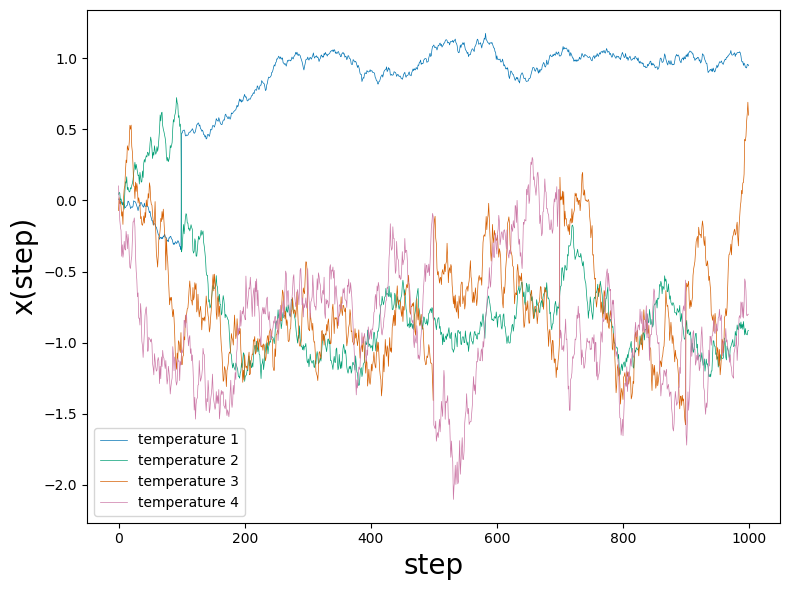

In [17]:
fig, ax = subplots(figsize=(8, 6))
for i = 1:nreplica
    ax.plot(traj_sorted[i], linewidth=0.5)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["temperature 1", "temperature 2", "temperature 3", "temperature 4"])
tight_layout()

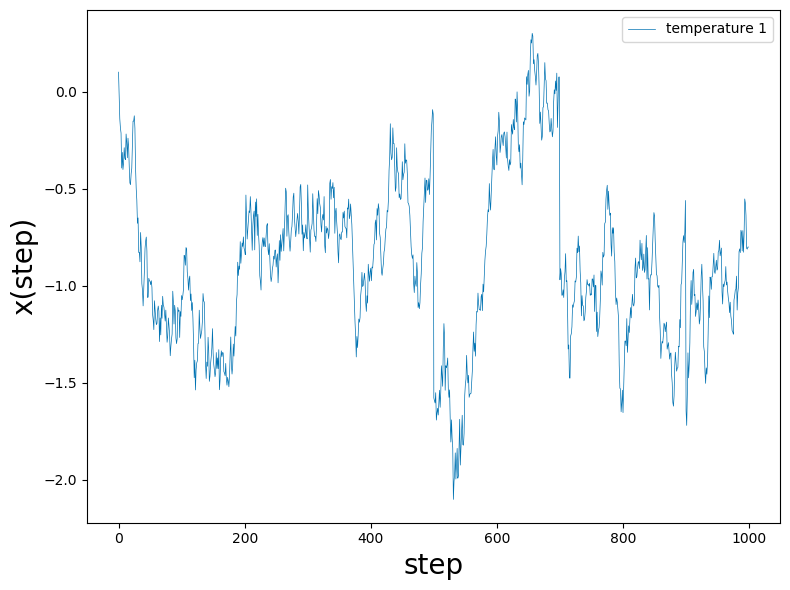

In [18]:
fig, ax = subplots(figsize=(8, 6))

    ax.plot(traj_sorted[4], linewidth=0.5)   

xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["temperature 1"])
tight_layout()

In [19]:
x_grid = range(-1.3, 1.3, length=100);
pmf_theory = V.(x_grid, k=1) ./ temperature_replica[1]
pmf_theory .= pmf_theory .- minimum(pmf_theory);

In [20]:
pmf_observed, _ = getpmf(traj_sorted[1], grid_x = collect(x_grid), bandwidth=0.05);

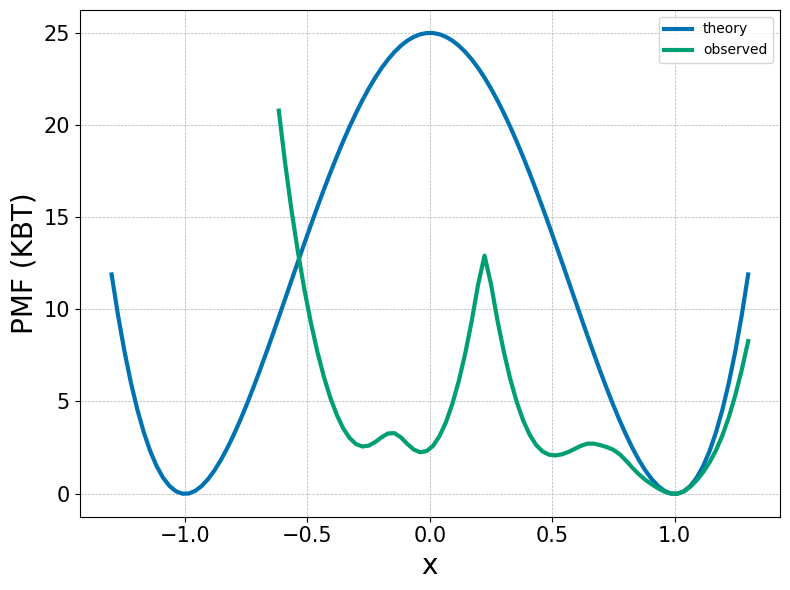

In [21]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(x_grid, pmf_theory, linewidth=3)
xlabel("x",fontsize=20)
ylabel("PMF (KBT)",fontsize=20)

ax.plot(x_grid, pmf_observed, linewidth=3)

ax.legend(["theory", "observed"])

ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()
savefig("md_replica_exchange.png", dpi=350)